In [4]:
%matplotlib inline
#import sys, traceback
import cv2
import imutils
import numpy as np
import matplotlib
#import matplotlib.pyplot as plt
#matplotlib.use("TkAgg")
from plantcv import plantcv as pcv

class options:
    def __init__(self):
        self.image = "img/tutorial_images/vis/original_image.jpg"
        self.debug = "plot"
        self.writeimg = False
        self.result = "./vis_tutorial_results"
        self.outdir = "."
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


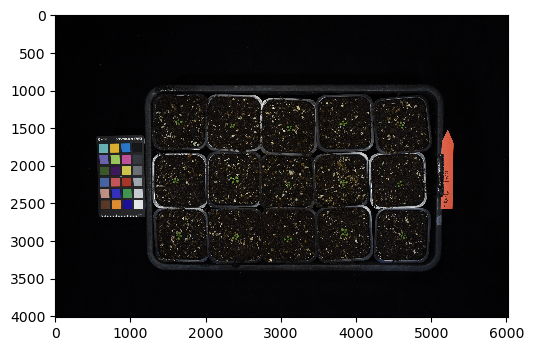

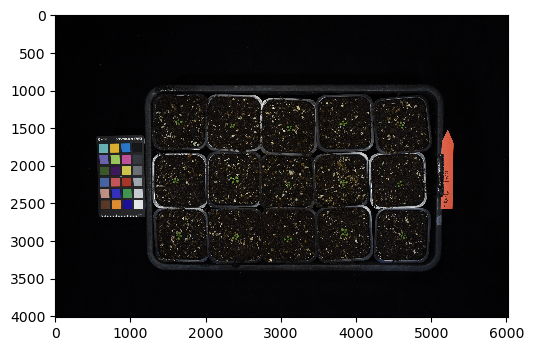

In [5]:
### Main pipeline

    # Read image
    img, path, filename = pcv.readimage("/home/leonard/Documents/Uni/PhD/Phenotyping/2020-01_LAC_phenotyping/pipeline_test/2020-01-28_tray1.JPG")    
    # Read ref image
    ref_img, ref_path, ref_filename = pcv.readimage("/home/leonard/Documents/Uni/PhD/Phenotyping/2020-01_LAC_phenotyping/pipeline_test/2020-01-28_tray1.JPG")

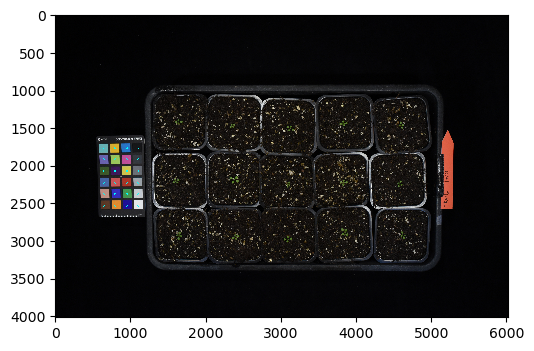

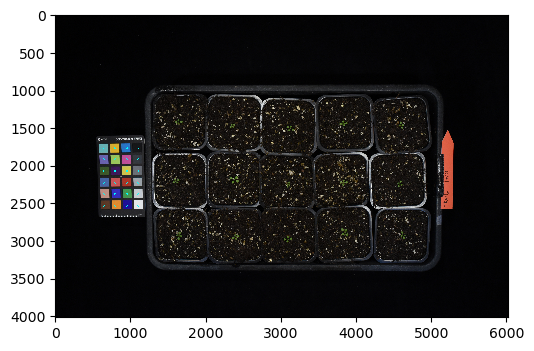

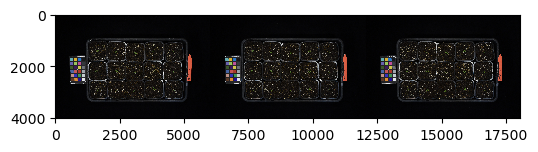

/home/leonard/Applications/miniconda3/envs/plantcv/lib/python3.6/site-packages/plotnine/coords/coord_cartesian.py:31: MatplotlibDeprecationWarning: 
The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  self.limits = Bunch(xlim=xlim, ylim=ylim)
/home/leonard/Applications/miniconda3/envs/plantcv/lib/python3.6/copy.py:274: MatplotlibDeprecationWarning: 
The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  y = func(*args)
/home/leonard/Applications/miniconda3/envs/plantcv/lib/python3.6/site-packages/plotnine/scales/scale.py:89: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/leonard/Applications/miniconda3/envs/plantcv/lib/python3.6/site-packages/plotnine/utils.py:284: FutureWarning: Method .as_matrix will be 

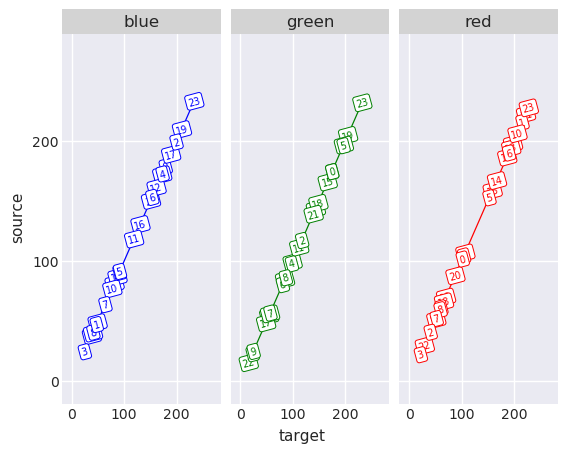

<ggplot: (-9223363299779948533)>


In [6]:
df, start, space = pcv.transform.find_color_card(rgb_img=ref_img)
target_mask = pcv.transform.create_color_card_mask(rgb_img=ref_img, radius=10, start_coord=start, spacing=space, ncols=4, nrows=6)

df, start, space = pcv.transform.find_color_card(rgb_img=img)
source_mask = pcv.transform.create_color_card_mask(rgb_img=img, radius=10, start_coord=start, spacing=space, ncols=4, nrows=6)

output_directory = "."

target_matrix, source_matrix, transformation_matrix, corrected_img = pcv.transform.correct_color(ref_img, target_mask, img, source_mask, output_directory)
pcv.transform.quick_color_check(source_matrix = source_matrix, target_matrix = target_matrix, num_chips = 24)

In [7]:
x_cc,y_cc,w_cc,h_cc = cv2.boundingRect(source_mask)
x_cc = int(round(x_cc * 1.3))
w_cc = int(round(w_cc * 1.3))

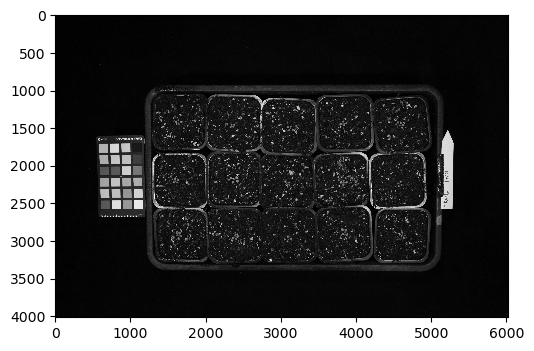

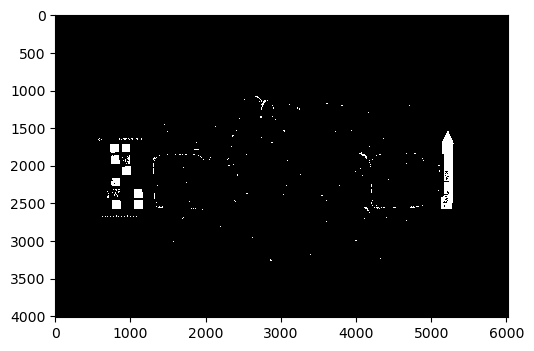

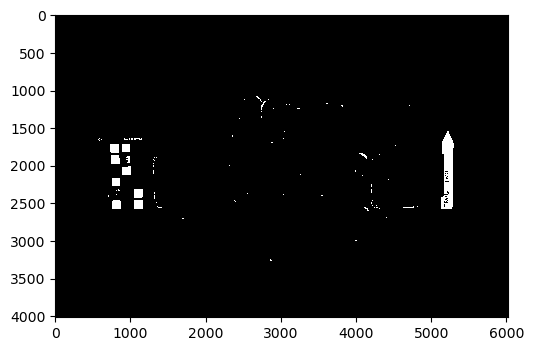

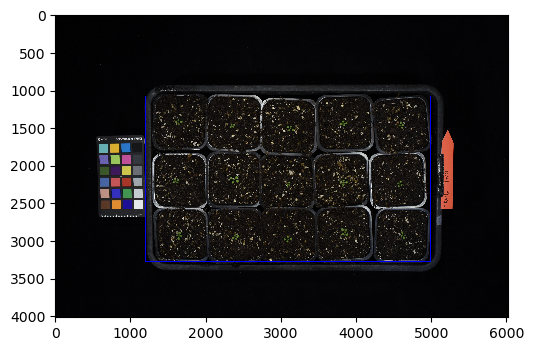

In [8]:
    #Crop tray
    #Convert RGB to HSV and extract the value channel
    h = pcv.rgb2gray_hsv(img, "v")
    # Threshold the value image
    v_thresh = pcv.threshold.binary(h, 190, 255, "light")
    v_mblur = pcv.median_blur(v_thresh, 10)
    #roi_contour, roi_hierarchy = pcv.roi.from_binary_image(img=img, bin_img=v_thresh)
    #crop_img = pcv.auto_crop(img, id_objects[0], 20, 20, 'black')
   
    x,y,w,h = cv2.boundingRect(v_mblur)
    #box = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    #cv2.drawContours(img,[box],0,(0,0,255),2)
    roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=x+w_cc, y=y, h=h, w=w-w_cc-space[1]*2)
    #print(roi_contour)
    #crop_img = img[tuple(roi_contour)]
    crop_img = img[y:y+h, x+w_cc:x+w-space[1]*2]
    
    crop_img = imutils.resize(crop_img, width=4500)
    
    
    #rect = cv2.minAreaRect(v_mblur)
    #box = cv2.boxPoints(rect)
    #box = np.int0(box)
    

    
    

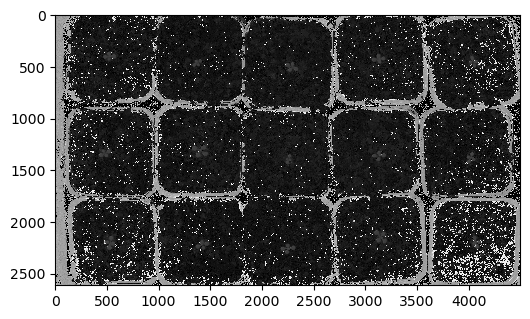

In [9]:
    # Convert RGB to HSV and extract the hue channel
    h = pcv.rgb2gray_hsv(crop_img, "h")

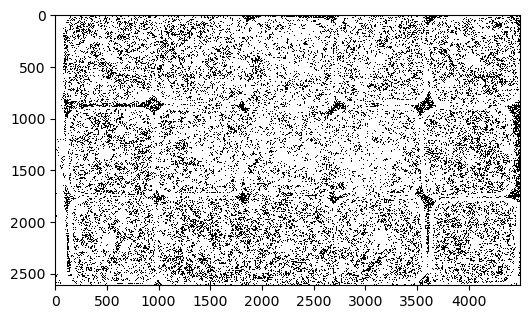

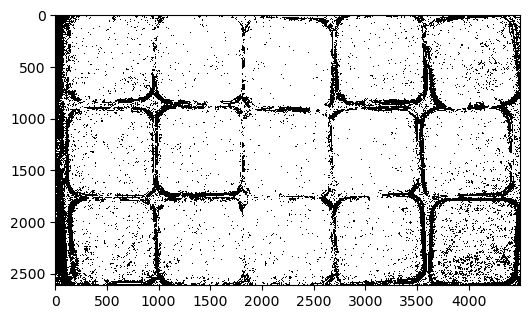

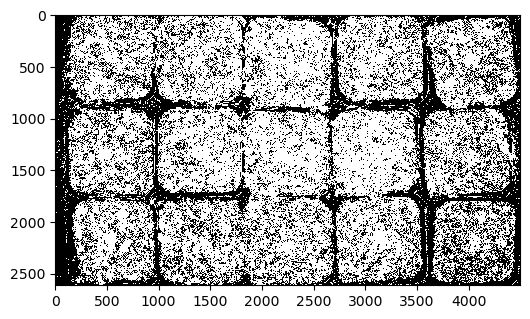

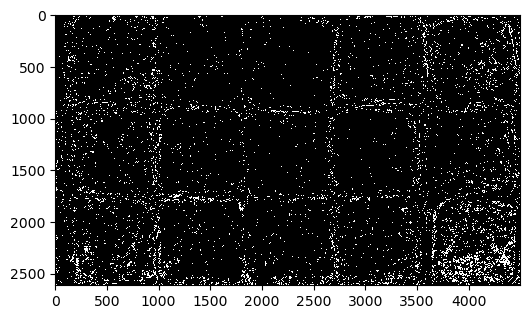

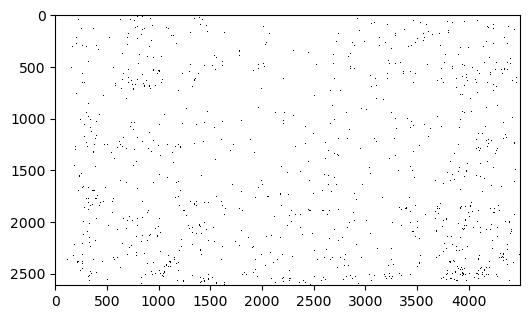

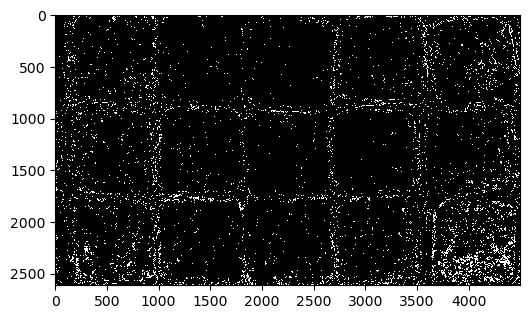

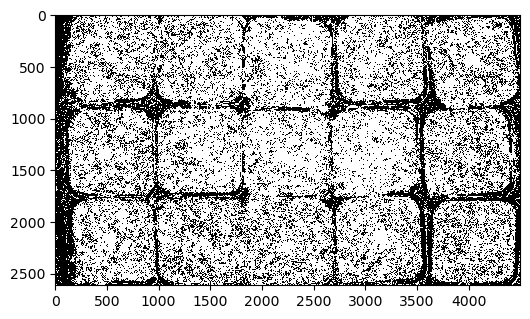

In [10]:
    # Threshold the hue image
    h_thresh1_1 = pcv.threshold.binary(h, 10, 255, "light")
    h_thresh1_2 = pcv.threshold.binary(h, 80, 255, "dark")
    h_thresh1 = pcv.logical_and(h_thresh1_1, h_thresh1_2)
    h_thresh2_1 = pcv.threshold.binary(h, 125, 255, "light")
    h_thresh2_2 = pcv.threshold.binary(h, 170, 255, "dark")
    h_thresh2 = pcv.logical_and(h_thresh2_1, h_thresh2_2)
    
    h_thresh = pcv.logical_or(h_thresh1, h_thresh2)

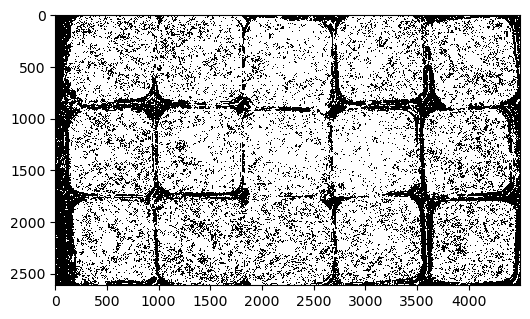

In [11]:
    # Median Blur
    h_mblur = pcv.median_blur(h_thresh, 5)
    #h_cnt = pcv.median_blur(h_thresh, 5)

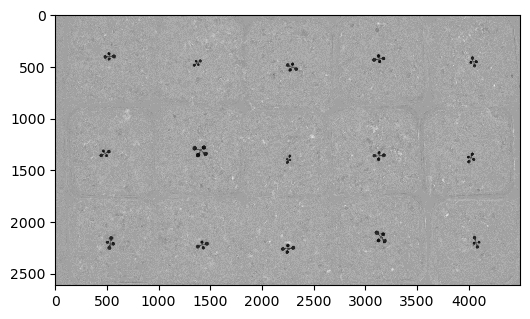

In [12]:
    # Convert RGB to LAB and extract the a channel
    a = pcv.rgb2gray_lab(crop_img, "a")
    #pcv.print_image(a, "a_channel.png")

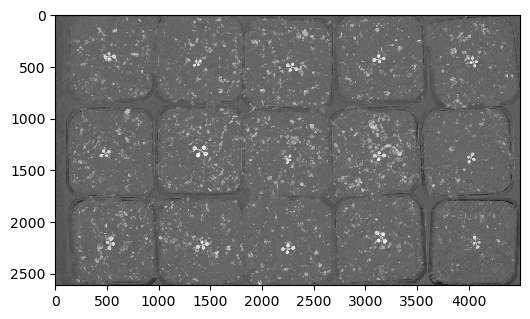

In [13]:
# Convert RGB to LAB and extract the b channel
    b = pcv.rgb2gray_lab(crop_img, "b")
    #pcv.print_image(b, "b_channel.png")

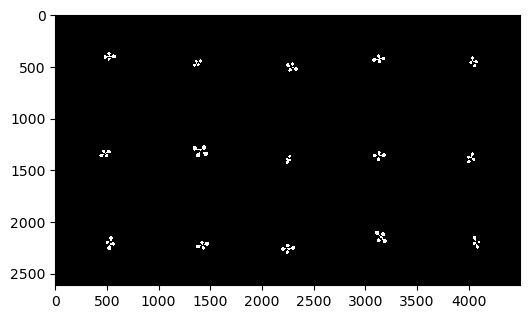

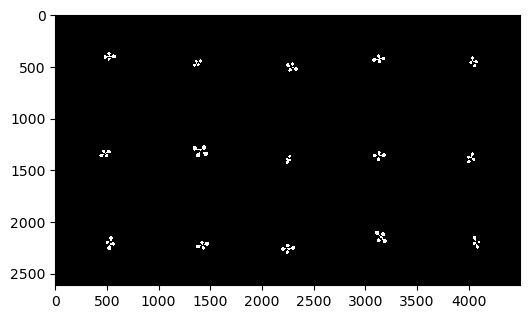

In [14]:
    # Threshold the blue image
    a_thresh = pcv.threshold.binary(a, 115, 255, "dark")
    a_cnt = pcv.threshold.binary(a, 115, 255, "dark")
    #pcv.print_image(a_cnt, "a_cnt.png")

In [15]:
   # Join the thresholded saturation and blue-yellow images
   # commented out, hue method too insensitive here
    #bh = pcv.logical_or(h_mblur, b_cnt)
    ah = a_cnt

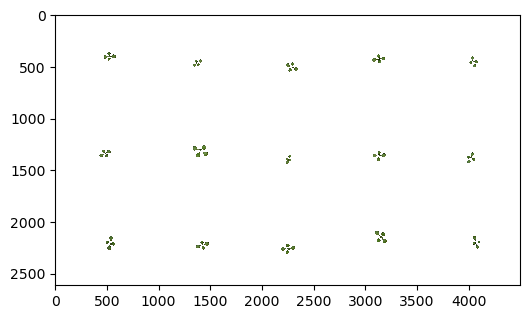

In [16]:
    # Apply Mask (for VIS images, mask_color=white)
    masked = pcv.apply_mask(crop_img, ah, "white")

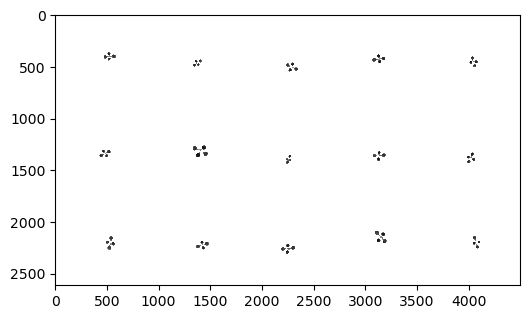

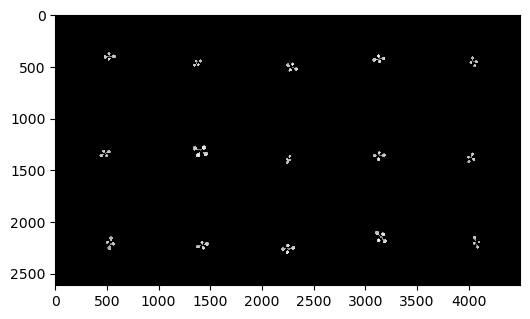

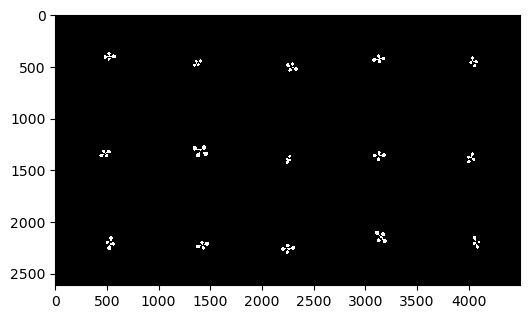

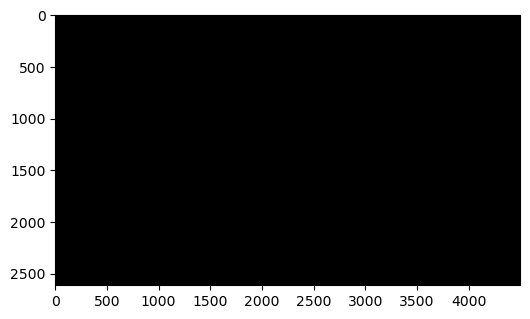

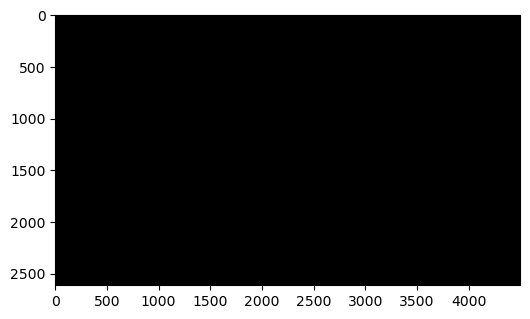

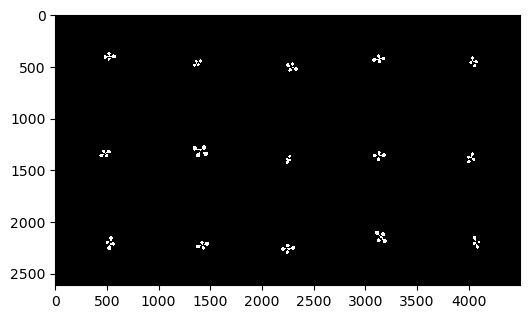

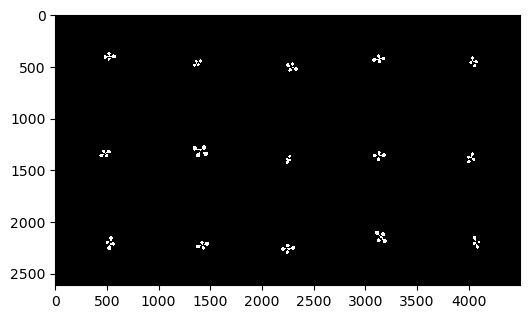

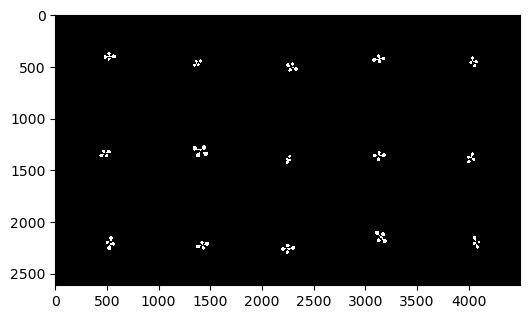

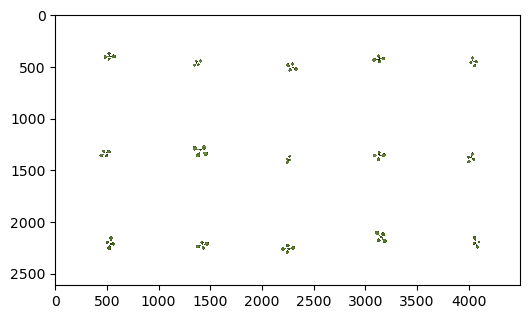

In [17]:

    # Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
    masked_a = pcv.rgb2gray_lab(masked, "a")
    masked_b = pcv.rgb2gray_lab(masked, "b")

    # Threshold the green-magenta and blue images
    maskeda_thresh = pcv.threshold.binary(masked_a, 116, 255, "dark")
    maskeda_thresh1 = pcv.threshold.binary(masked_a, 135, 255, "light")
    maskedb_thresh = pcv.threshold.binary(masked_b, 125, 255, "light")

    # Join the thresholded saturation and blue-yellow images (OR)
    ab1 = pcv.logical_or(maskeda_thresh, maskeda_thresh1)
    ab = pcv.logical_and(maskedb_thresh, ab1)

    # Fill small objects
    ab_fill = pcv.fill(ab, 200)

    # Apply mask (for VIS images, mask_color=white)
    masked2 = pcv.apply_mask(masked, ab_fill, "white")

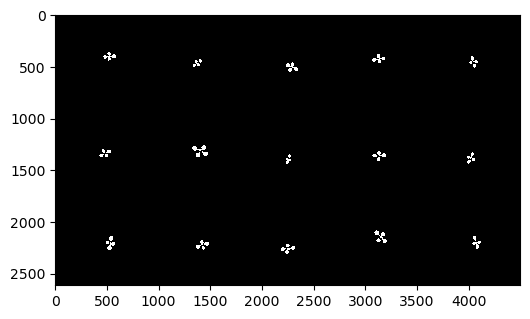

In [18]:
# STEP 8: Dilate so that you don't lose leaves (just in case)
# Inputs:
#    img    = input image
#    kernel = integer
#    i      = iterations, i.e. number of consecutive filtering passes

dilated = pcv.dilate(ab_fill, 3, 1)
pcv.print_image(dilated, "dilated.png")

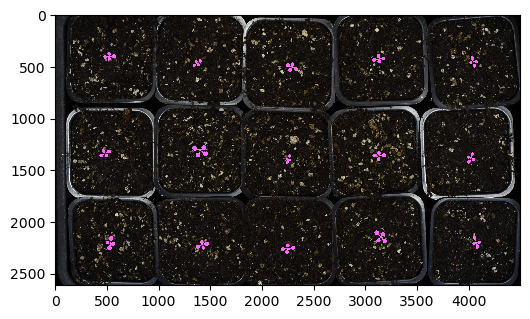

In [19]:
# STEP 9: Find objects (contours: black-white boundaries)
# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection

id_objects, obj_hierarchy = pcv.find_objects(crop_img, dilated)

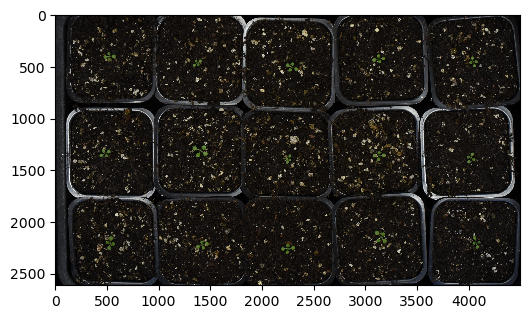

In [20]:
# STEP 10: Define region of interest (ROI)
# Inputs:
#    x     = The x-coordinate of the upper left corner of the rectangle.
#    y     = The y-coordinate of the upper left corner of the rectangle.
#    w     = The height of the rectangle.
#    h     = The width of the rectangle.
#    img   = An RGB or grayscale image to plot the ROI on.
#    roi_contour, roi_hierarchy = pcv.roi.rectangle(5, 90, 200, 390, img1)                                                ^                ^
#                                                  |______________|
#                                            adjust these four values

roi_contour, roi_hierarchy = pcv.roi.rectangle(crop_img, 0, 0, 2500, 4500)

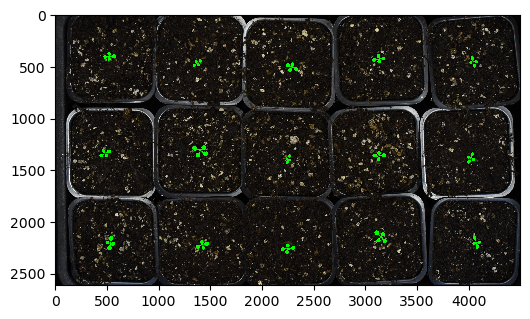

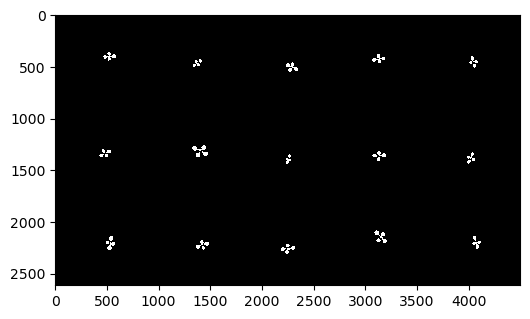

In [21]:
# STEP 12: Keep objects that overlap with the ROI
# Inputs:
#    img            = img to display kept objects
#    roi_type       = 'cutto' or 'partial' (for partially inside)
#    roi_contour    = contour of roi, output from "View and Ajust ROI" function
#    roi_hierarchy  = contour of roi, output from "View and Ajust ROI" function
#    object_contour = contours of objects, output from "Identifying Objects" fuction
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" fuction

roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img = crop_img, 
                                                                      roi_type = 'partial', 
                                                                      roi_contour = roi_contour,
                                                                      roi_hierarchy = roi_hierarchy, 
                                                                      object_contour = id_objects, 
                                                                      obj_hierarchy=obj_hierarchy)


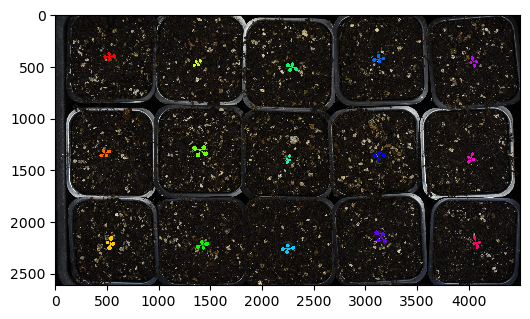

In [22]:
# STEP 13: This function take a image with multiple contours and
# clusters them based on user input of rows and columns

# Inputs:
#    img               = An RGB image
#    roi_objects       = object contours in an image that are needed to be clustered.
#    roi_obj_hierarchy = object hierarchy
#    nrow              = number of rows to cluster (this should be the approximate  number of desired rows in the entire image even if there isn't a literal row of plants)
#    ncol              = number of columns to cluster (this should be the approximate number of desired columns in the entire image even if there isn't a literal row of plants)

clusters, contours, hierarchies = pcv.cluster_contours(crop_img, roi_objects, roi_obj_hierarchy, 3, 5)

This function has been updated to include object hierarchy so object holes can be included


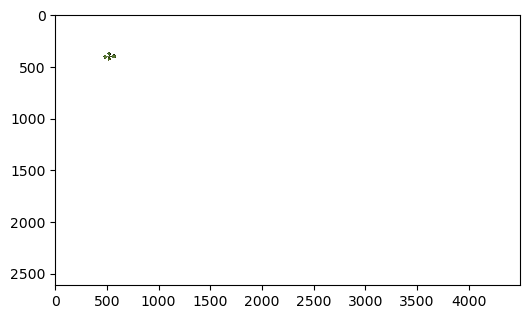

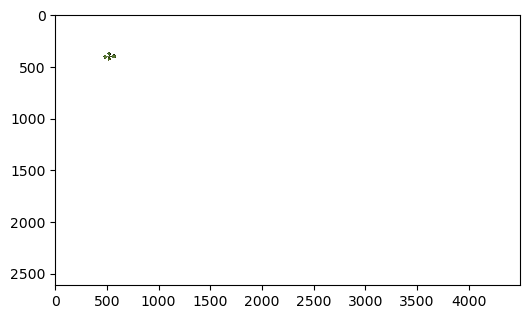

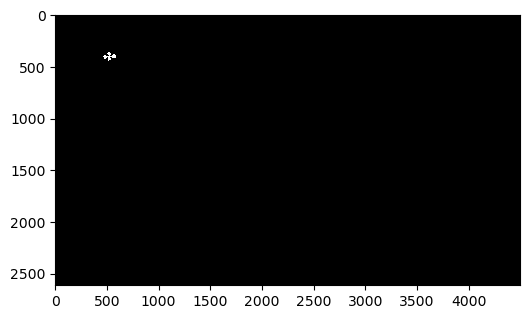

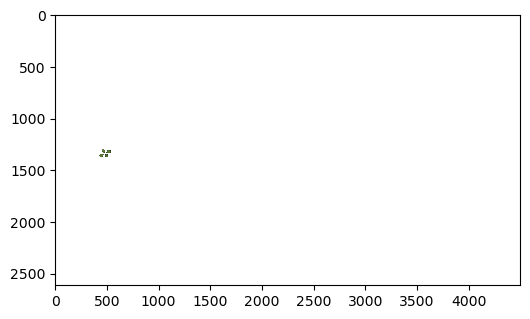

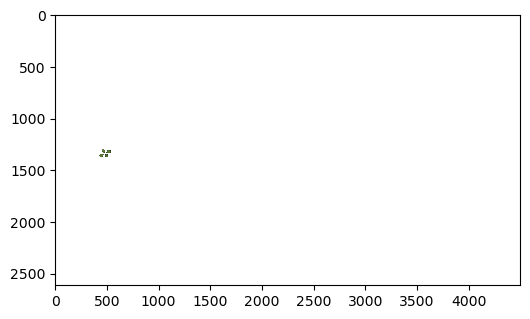

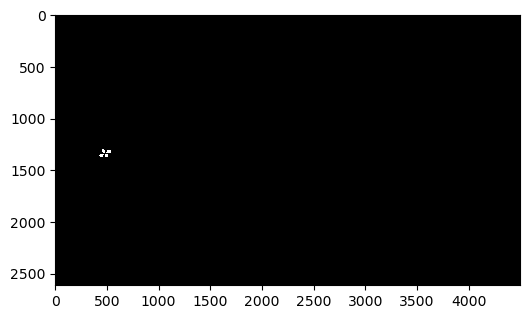

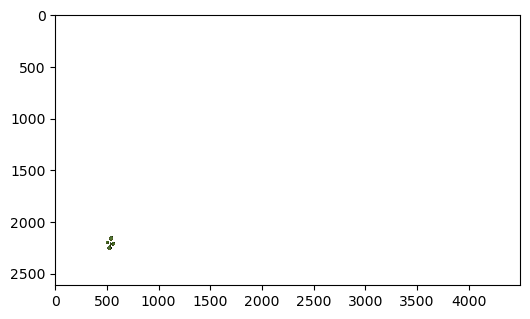

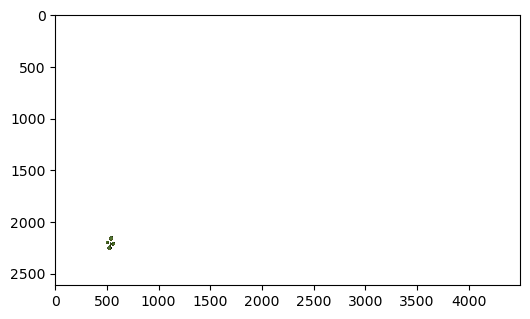

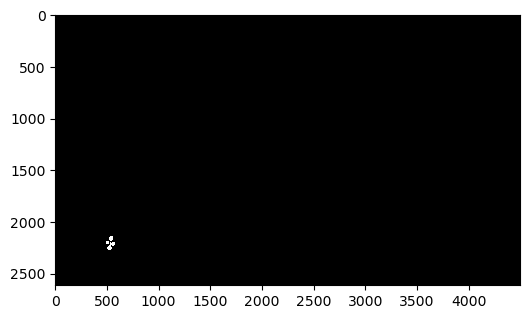

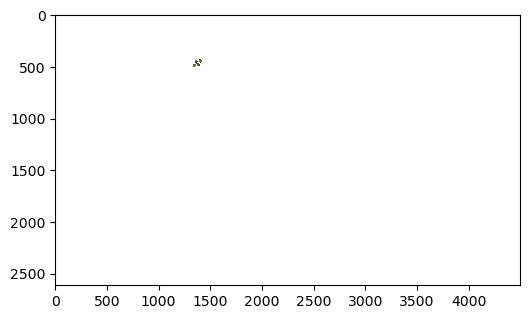

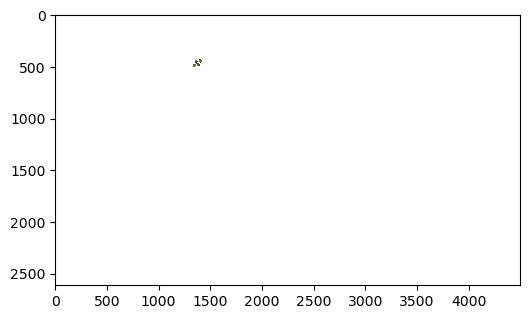

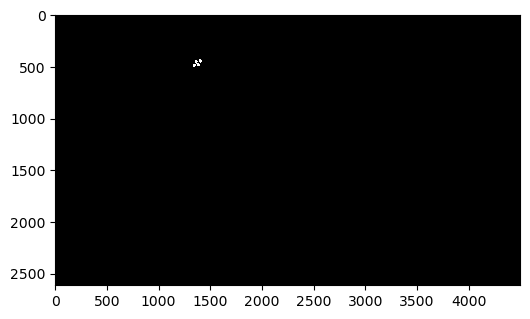

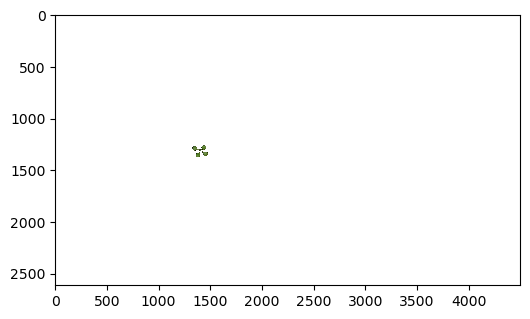

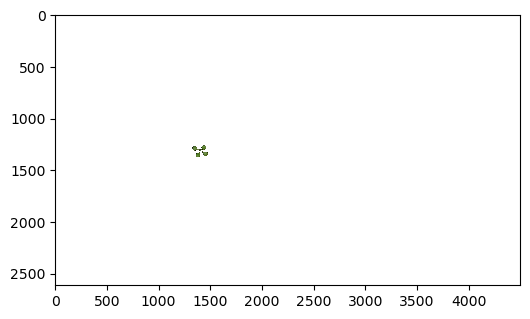

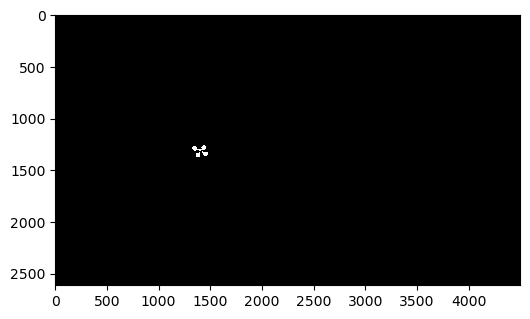

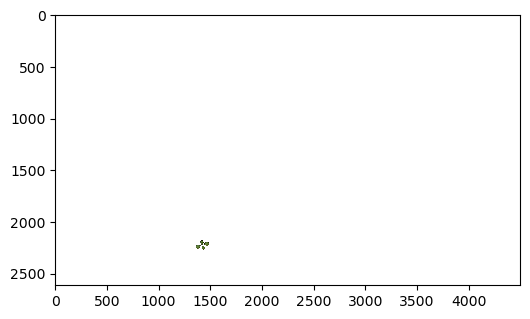

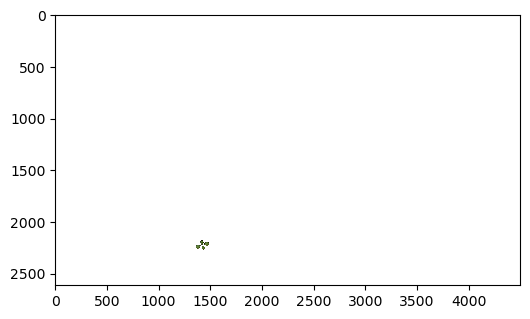

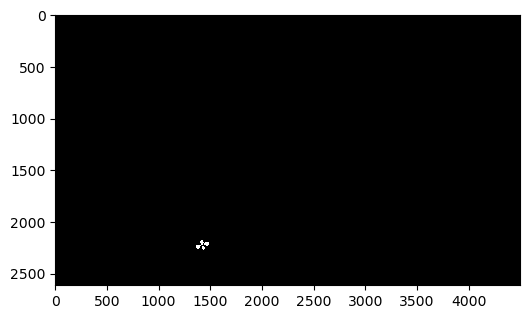

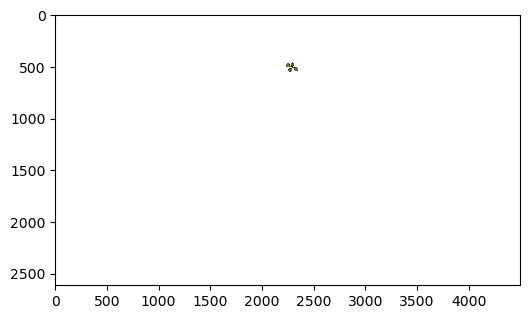

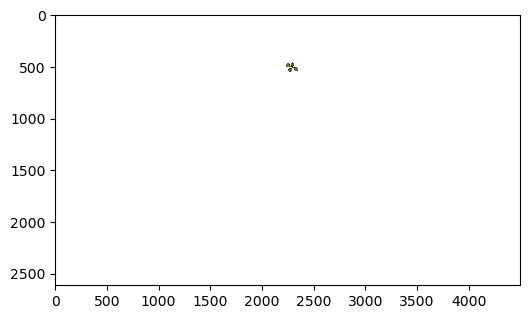

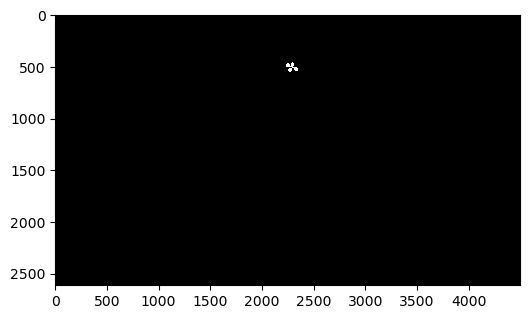

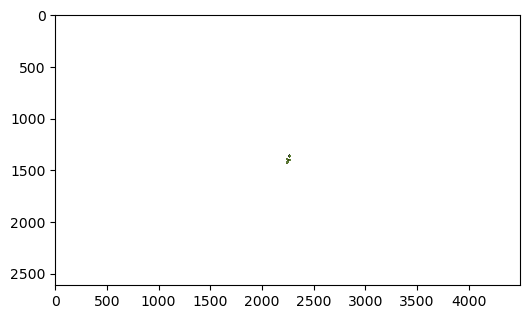

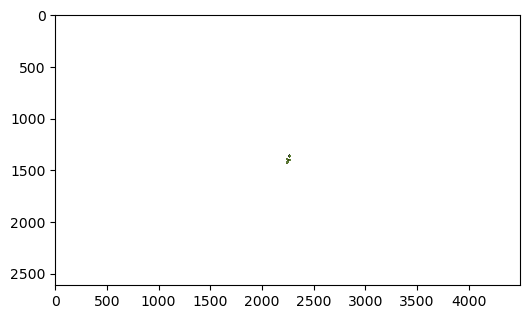

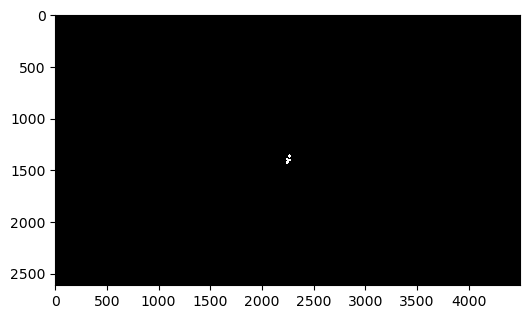

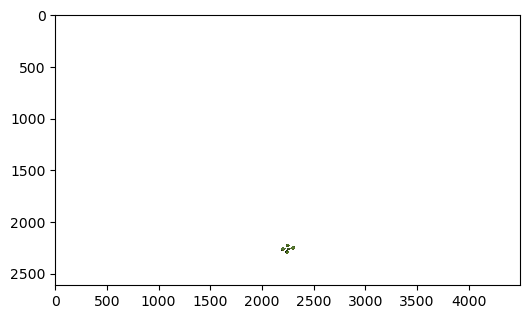

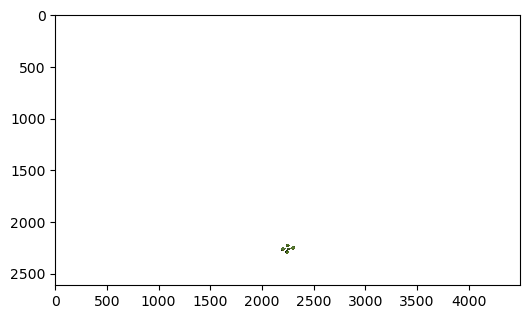

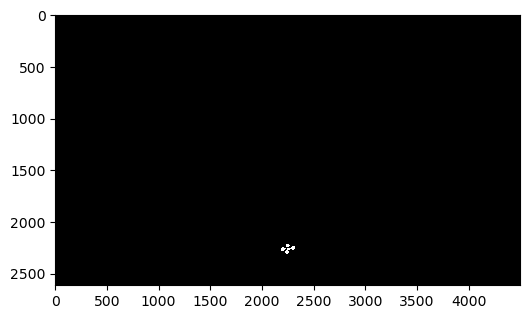

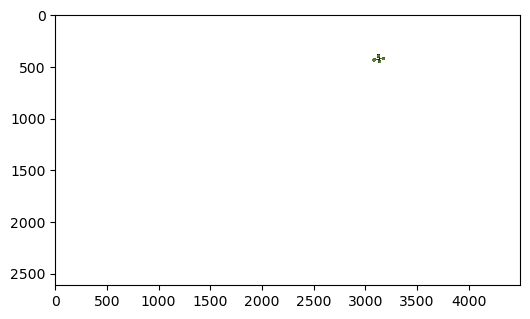

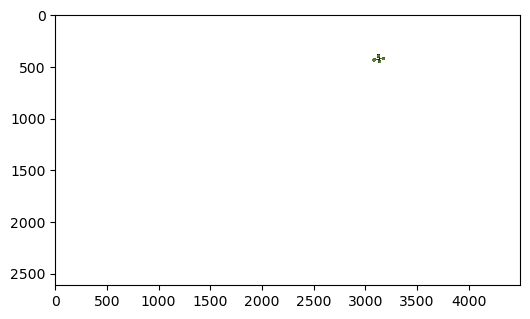

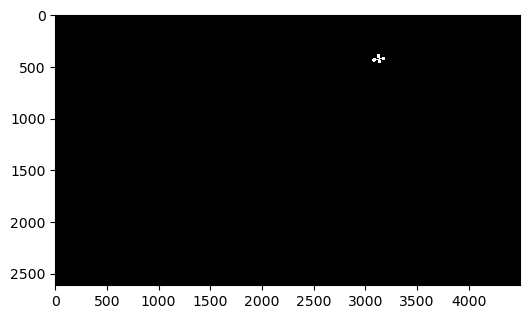

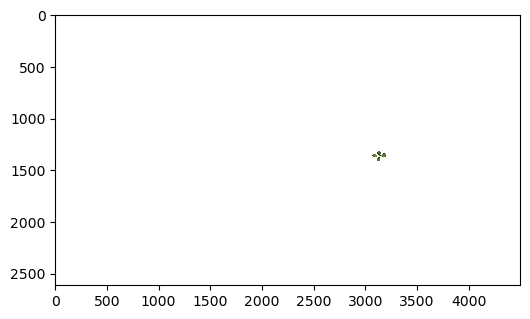

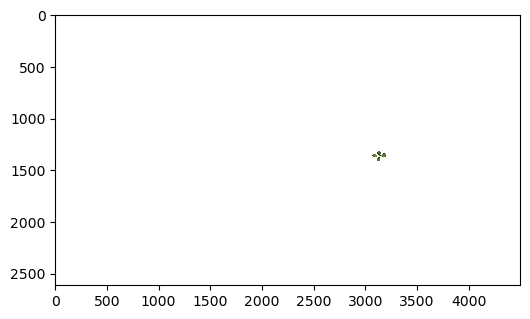

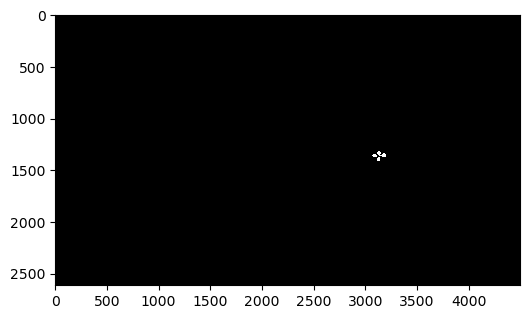

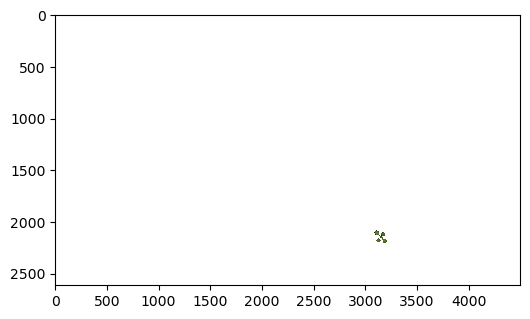

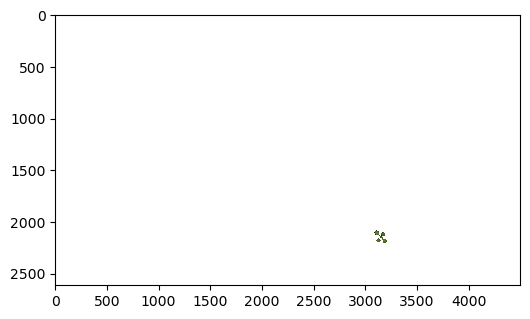

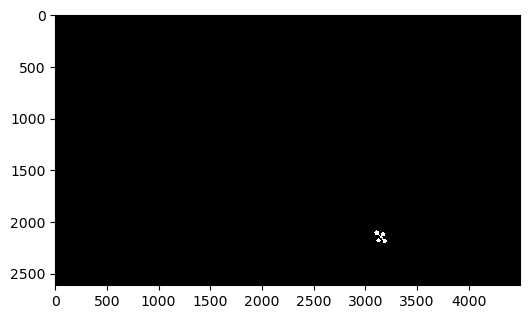

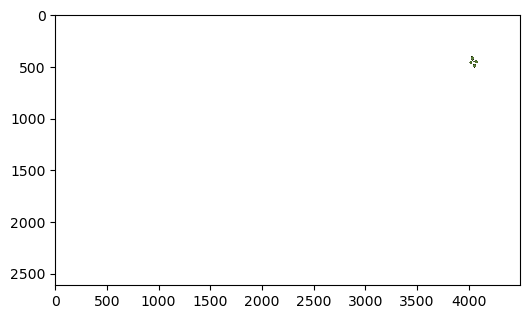

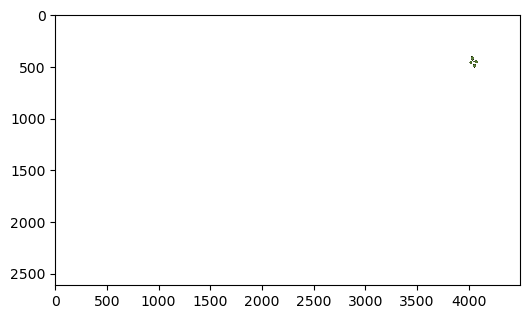

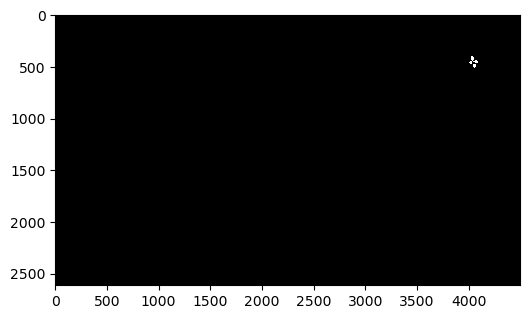

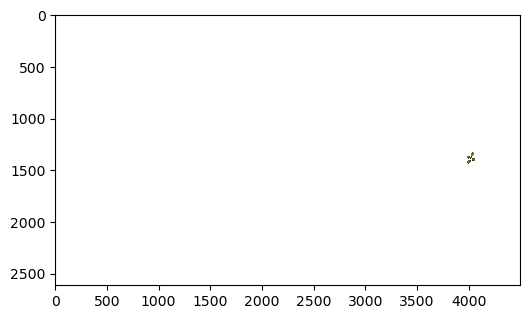

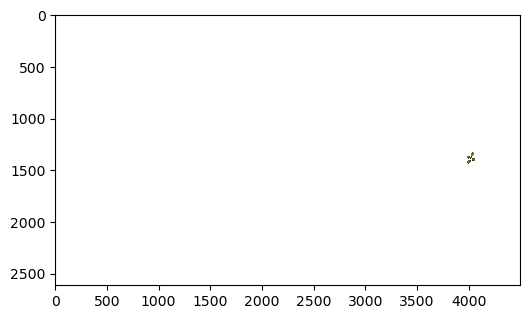

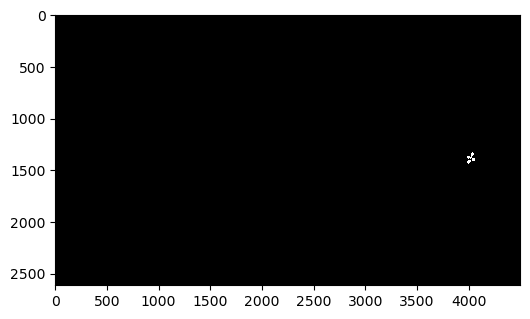

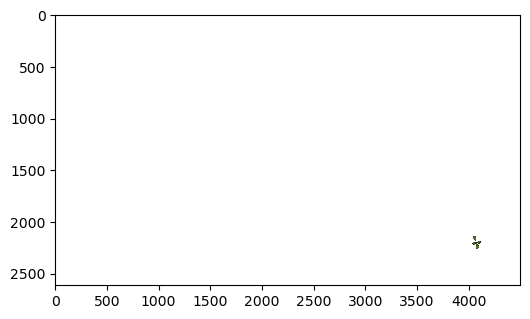

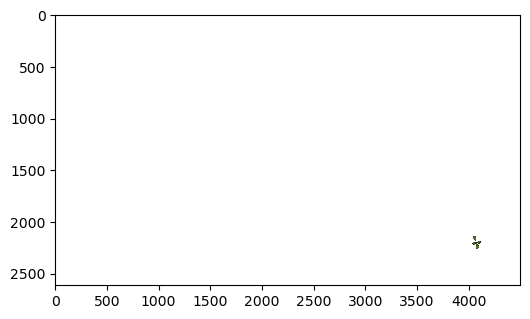

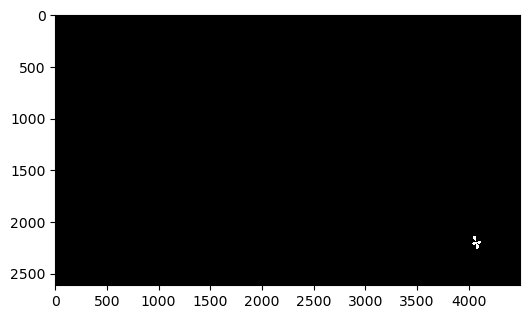

In [23]:
# STEP 14: This #function takes clustered contours and splits them into multiple images,
# also does a check to make sure that the number of inputted filenames matches the number
# of clustered contours. If no filenames are given then the objects are just numbered
# Inputs:
#    img                     = ideally a masked RGB image.
#    grouped_contour_indexes = output of cluster_contours, indexes of clusters of contours
#    contours                = contours to cluster, output of cluster_contours
#    hierarchy               = object hierarchy
#    outdir                  = directory for output images
#    file                    = the name of the input image to use as a base name , output of filename from read_image function
#    filenames               = input txt file with list of filenames in order from top to bottom left to right (likely list of genotypes)

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
# Un-comment the line below to see the split up contours print to the output directory 
#pcv.params.debug = "print"

out = args.outdir

# If you have a list of treatments, genotypes, etc. You would input a .txt file with them to help save
# the contours by names, add it to the options class and then add filenames=names to the 
# splitimg function below.  
#names = args.names

output_path = pcv.cluster_contour_splitimg(crop_img, clusters, contours, 
                                           hierarchies, out, file=filename)

In [25]:
# Make a grid of ROIs 
rois1, roi_hierarchy1 = pcv.roi.multi(img=crop_img, coord=(450,450), radius=399, spacing=(880, 880), nrows=3, ncols=5)

# Specify a list of coordinates of desired ROIs 
#rois2, roi_hierarchy2 = pcv.roi.multi(img=img1, coord=[(25,120), (165,260), (310, 260)], radius=20)

In [26]:
img_copy = np.copy(crop_img)

for i in range(0, len(rois1)):
    roi = rois1[i]
    hierarchy = roi_hierarchy1[i]
    # Find objects
    filtered_contours, filtered_hierarchy, filtered_mask, filtered_area = pcv.roi_objects(
        img=crop_img, roi_type="partial", roi_contour=roi, roi_hierarchy=hierarchy, object_contour=id_objects, 
        obj_hierarchy=obj_hierarchy)
    if len(filtered_contours) > 0:
        # Combine objects together in each plant     
        plant_contour, plant_mask = pcv.object_composition(img=crop_img, contours=filtered_contours, hierarchy=filtered_hierarchy)        

        # Analyze the shape of each plant 
        analysis_images = pcv.analyze_object(img=img_copy, obj=plant_contour, mask=plant_mask)

        # Determine color properties: Histograms, Color Slices, output color analyzed histogram (optional)
        color_images = pcv.analyze_color(img_copy, plant_mask, "hsv")

        # Watershed plant area to count leaves
        watershed_images = pcv.watershed_segmentation(img_copy, plant_mask, 10)

        # Save the image with shape characteristics 
        #img_copy = analysis_images[0]

        # Print out a text file with shape data for each plant in the image 
        #pcv.print_results(filename = 'prefix_' + str(i) + '.txt')
        # Clear the measurements stored globally into the Ouptuts class
        # results.append(watershed_header, watershed_data)
        print(pcv.outputs.observations)
        pcv.outputs.clear()
    

# Plot out the image
# pcv.plot_image(img_copy)

/home/leonard/Applications/miniconda3/envs/plantcv/lib/python3.6/site-packages/plotnine/coords/coord_cartesian.py:31: MatplotlibDeprecationWarning: 
The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  self.limits = Bunch(xlim=xlim, ylim=ylim)
/home/leonard/Applications/miniconda3/envs/plantcv/lib/python3.6/copy.py:274: MatplotlibDeprecationWarning: 
The Bunch class was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use types.SimpleNamespace instead.
  y = func(*args)
/home/leonard/Applications/miniconda3/envs/plantcv/lib/python3.6/site-packages/plotnine/scales/scale.py:89: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):


{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 4590.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 6703.0, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.6847680143219455, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 640.3549960851669, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 1

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 3171.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 4570.5, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.6937971775516902, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 490.8297302722931, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 8

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 4615.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 7676.0, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.601224596143825, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 714.706480383873, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 119

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 4970.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 7597.5, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.6541625534715367, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 674.1198465824127, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 1

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 3935.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 6039.0, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.6515979466799139, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 657.2984391450882, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 8

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 4072.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 6555.5, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.6211578064220883, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 750.8047168254852, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 1

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 7540.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 13689.0, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.5508072174738842, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 931.2805190086365, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 2620.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 3529.5, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.7423147754639468, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 414.3320828676224, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 5

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 4752.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 8127.0, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.584717607973422, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 733.4077900648117, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 13

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 3933.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 6343.0, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.6200536023963424, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 672.3267802000046, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 8

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 5418.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 8355.5, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.6484351624678355, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 710.2280761003494, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 9

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 4750.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 7610.0, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.6241787122207622, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 741.5458376407623, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 1

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 5449.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 8923.0, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.610669057491875, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 727.3922199010849, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 14

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 6617.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 11134.0, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.5943057301957967, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 858.6527856588364, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 

{'in_bounds': {'trait': 'whether the plant goes out of bounds ', 'method': 'plantcv.plantcv.within_frame', 'scale': 'none', 'datatype': "<class 'bool'>", 'value': True, 'label': 'none'}, 'area': {'trait': 'area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 3991.0, 'label': 'pixels'}, 'convex_hull_area': {'trait': 'convex hull area', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 6637.0, 'label': 'pixels'}, 'solidity': {'trait': 'solidity', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'none', 'datatype': "<class 'float'>", 'value': 0.6013259002561399, 'label': 'none'}, 'perimeter': {'trait': 'perimeter', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 640.0763297080994, 'label': 'pixels'}, 'width': {'trait': 'width', 'method': 'plantcv.plantcv.analyze_object', 'scale': 'pixels', 'datatype': "<class 'int'>", 'value': 7